In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

In [149]:
%%capture capt
%run 3_userAnalysis.ipynb

In [150]:
movies['overview'].head()

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

##### TfidfVectorizer generates a mxn matrix with m equal to the total rows of  dataset & n is total no of different words used in overview column. Using this matrix we can find the similarity among the movies 

In [151]:
tfidf = TfidfVectorizer(stop_words='english')
overviewMatrix = tfidf.fit_transform(movies['overview'])
print("shape", overviewMatrix.shape)

shape (3394, 17282)


##### Used cosine similarity to find the similarity among movies. It generates a matrix with similarity scores mapping with all movies in dataset

In [152]:
overviewSimilarity = cosine_similarity(overviewMatrix, overviewMatrix)
pd.DataFrame(overviewSimilarity)

,0,1,2,3,4,5,6,7,8,9,...,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393
0,1.000000,0.000000,0.000000,0.026102,0.000000,0.028660,0.000000,0.039429,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.043716,0.000000
1,0.000000,1.000000,0.000000,0.000000,0.032127,0.000000,0.000000,0.021380,0.000000,0.000000,...,0.019819,0.0,0.000000,0.012739,0.010673,0.000000,0.0,0.000000,0.000000,0.000000
2,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.032868,0.026059,0.000000,...,0.017643,0.0,0.000000,0.000000,0.000000,0.029308,0.0,0.000000,0.000000,0.000000
3,0.026102,0.000000,0.000000,1.000000,0.010712,0.005312,0.013048,0.025608,0.020884,0.129094,...,0.013374,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
4,0.000000,0.032127,0.000000,0.010712,1.000000,0.000000,0.009462,0.036849,0.000000,0.018044,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,0.000000,0.000000,0.029308,0.000000,0.000000,0.017892,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.050474,0.000000,0.000000
3390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
3391,0.000000,0.000000,0.000000,0.000000,0.000000,0.017251,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.050474,0.0,1.000000,0.000000,0.033733
3392,0.043716,0.000000,0.000000,0.000000,0.000000,0.022191,0.000000,0.050031,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000


##### Similar score matrix data can be fetched by using index of the required row. So if user searches for a particular movie, we need to get the index of that movie and then get the similartiy scores data. For this conversion instead of converting each time during search we can make use of reverse map to store tiles as key & index as values. 
Once we get similarity scores for a particular movie, we need to sort them to find top 10 similar movies indices & then fetch the titles to recommend to the user. As any movie will have 1 as similarity score when compared with itself, its own index appears at top of list. So we ignore it and take next 10 items from the results. 

##### An example of fetching similar movies for index 0 

In [153]:
#sorting
sim_sorted = np.argsort(overviewSimilarity[0])
#top 10 
sim_indices = sim_sorted[::-1][:11]
#titles
sim_titles = movies.iloc[sim_indices]['title']
sim_titles[1:]

1875                    The American
597                       The Matrix
499                 Tears of the Sun
1466                           Hanna
298     The Adventures of Pluto Nash
883                 The Book of Life
731                        Supernova
798                         Semi-Pro
2319                   Birthday Girl
962                         Insomnia
Name: title, dtype: object

##### provided movieId and the similarity matrix, this function returns the top 10 similar movies 

In [201]:
def getTopSimilarMovies(movieId,similarity):
    moviesLimit = 3
    index = movieIdIndex[movieId]
    scores = similarity[index]
    score_sorted = np.sort(scores)
    score_index = np.argsort(scores)
    top = score_index[::-1][1:moviesLimit+1]
    recommendations = np.array(movies.iloc[top]['movieId'])
    return recommendations,score_sorted[::-1][1:moviesLimit+1]

##### provided userID and the similarity matrix, this function returns movie ids along with scores that have similarities with user top rated movies

In [199]:
def contentBasedRecom(randomUser,similarity):
    likedMovies = ratedMovies[ratedMovies['rating'] >= np.mean(ratedMovies['rating']) ]
    #topRatedMovies = ratedMovies.sort_values(['rating'],ascending=False)
    #if()
    ids = likedMovies['movieId']
    moviesDict = dict()
    for i in ids:
        movies,score = getTopSimilarMovies(i,similarity)
        for j in range(len(movies)):
            if(movies[j] in moviesDict):
                if(moviesDict[movies[j]] < score[j]):
                    moviesDict.update({movies[j]:score[j]})
            else:
                moviesDict[movies[j]] = score[j]
    duplicates = []
    for i in moviesDict:
        if(i in ratedMovies['movieId']):
            duplicates.append(i)
    for i in duplicates:
        moviesDict.pop(i)
    return moviesDict

##### Function to generate a list of movies that have similarities with top rated movies of user. 

In [180]:
def getContentRecomMovies(user,similarity):
    moviesDict = contentBasedRecom(user,similarity)
    recommendedMovieIds = moviesDict.keys()
    contentRecomIds = np.array(list(recommendedMovieIds))
    contentRecomDf = pd.DataFrame({'movieId':moviesDict.keys(),'score':moviesDict.values()})
    contentRecomDf = contentRecomDf.sort_values('score',ascending=False)
    contentRecomTitles = []
    for i in contentRecomIds:
        contentRecomTitles.append(movies['title'].iloc[movieIdIndex[i]])
    contentRecomDf['titles'] = contentRecomTitles
    contentRecomDf.head()
    return contentRecomDf

##### Get recommendation using overview column data. 

In [187]:
overviewRecommended = getContentRecomMovies(randomUser, overviewSimilarity)
overviewRecommended

,movieId,score,titles
210,136598,0.463754,Ghost Ship
110,260,0.421969,Niagara
109,1196,0.421969,Spider-Man 3
223,858,0.404356,The Amazing Spider-Man 2
264,1221,0.404356,Road to Perdition
...,...,...,...
25,1916,0.079890,Three Men and a Baby
91,1835,0.079693,Men in Black 3
92,2746,0.078937,Charly
273,5812,0.071500,Gangster Squad


<AxesSubplot:xlabel='score', ylabel='Count'>

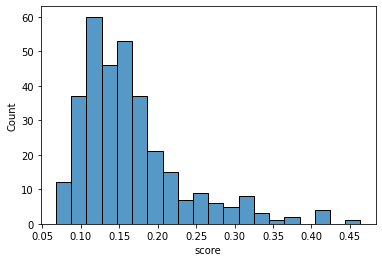

In [188]:
sns.histplot(overviewRecommended['score'])

##### Creating similarty scores for movies using content column 

In [158]:
contentMatrix = tfidf.fit_transform(movies['content'])
contentSimilarity = cosine_similarity(contentMatrix,contentMatrix)

In [159]:
contentMatrix

<3394x12500 sparse matrix of type '<class 'numpy.float64'>'
	with 45126 stored elements in Compressed Sparse Row format>

In [160]:
pd.DataFrame(contentSimilarity)

,0,1,2,3,4,5,6,7,8,9,...,3384,3385,3386,3387,3388,3389,3390,3391,3392,3393
0,1.000000,0.039005,0.022644,0.010369,0.038404,0.040423,0.0,0.041802,0.029744,0.042201,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013295,0.007773
1,0.039005,1.000000,0.022605,0.010351,0.021779,0.150126,0.0,0.023706,0.029693,0.042129,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007759
2,0.022644,0.022605,1.000000,0.027680,0.055377,0.023428,0.0,0.085812,0.012683,0.024458,...,0.00000,0.0,0.000000,0.000000,0.000000,0.013566,0.000000,0.043582,0.000000,0.020749
3,0.010369,0.010351,0.027680,1.000000,0.010780,0.010728,0.0,0.011734,0.000000,0.086262,...,0.00000,0.0,0.000000,0.005759,0.112284,0.014218,0.006695,0.024554,0.013516,0.030382
4,0.038404,0.021779,0.055377,0.010780,1.000000,0.110970,0.0,0.043459,0.012219,0.023563,...,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.028444,0.013821,0.008081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3389,0.000000,0.000000,0.013566,0.014218,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00863,0.0,0.005989,0.005852,0.006902,1.000000,0.000000,0.029263,0.000000,0.010658
3390,0.000000,0.000000,0.000000,0.006695,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.005646,0.000000,0.000000,1.000000,0.000000,0.004932,0.000000
3391,0.000000,0.000000,0.043582,0.024554,0.028444,0.000000,0.0,0.000000,0.000000,0.000000,...,0.00000,0.0,0.000000,0.000000,0.000000,0.029263,0.000000,1.000000,0.007234,0.018406
3392,0.013295,0.000000,0.000000,0.013516,0.013821,0.000000,0.0,0.015045,0.000000,0.000000,...,0.00000,0.0,0.000000,0.004242,0.000000,0.000000,0.004932,0.007234,1.000000,0.006361


##### Get recommendations using content column of the dataset

In [192]:
contentRecommended = getContentRecomMovies(randomUser, contentSimilarity)
contentRecommended

,movieId,score,titles
78,6333,0.994320,The Day the Earth Stood Still
16,7153,0.912415,Revolutionary Road
15,5952,0.813651,Flushed Away
38,4993,0.813651,Laws of Attraction
101,6934,0.802803,Little Black Book
...,...,...,...
675,1278,0.089587,The Wrestler
676,3671,0.089397,The Fountain
661,3869,0.088854,The Imitation Game
662,44972,0.086043,Black Swan


<AxesSubplot:xlabel='score', ylabel='Count'>

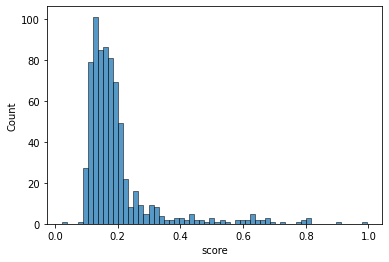

In [193]:
sns.histplot(contentRecommended['score'])